In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys 
sys.path.append('../')
from utils import *

%matplotlib inline
import matplotlib as mpl
mpl_params = {'legend.fontsize': 15,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Sampling from a Negative Binomial (NB) distribution

To better control and compare the prior parameters of the NB we sample from it indirectly by sampling from a Poisson distribution with parameter $\lambda$ which we sample from a Gamma distribution for which we define prior parameters $k$ and $\theta$. On these prior parameters we again choose Gamma priors with fixed parameters. 

Normally, a negative binomial is defined as the probability distribution describing the number of successes $k$ in a sequence of independent Bernoulli trials before a predefined number of $r$ failures happen, or vice versa, the number of failures $k$ before a predefined number of successes $r$, given a probability of success / failure $p$.  

\begin{align}
p(k | r, p) &= {k + r - 1 \choose k} (1 - p)^r p^k
\end{align}

However, it can also be described as a mixture of a Poisson and a Gamma distribution, such that the $\lambda$ parameter of the mean of the Poisson is itself a RV following a Gamma distribution with shape parameter $k$ and scale parameter $\theta$. If we choose $k=r$ and $\theta = p/(1-p)$ then we can show that the expectation over $\lambda$ follows a negative binomial distribution: 

\begin{align}
f(k, r, p) &= \int_0^{\infty} f_{Poisson(\lambda)}(k) \;\; f_{Gamma(r, (1-p)/p)}(\lambda) d\lambda \\
            &= \int_0^{\infty} \frac{\lambda^k}{k!} e^{-\lambda} \lambda^{r - 1} \frac{e^{-\lambda (1-p)/p}}{\left(\frac{1-p}{p}\right )^r \Gamma(r)} d\lambda \\
            &= \frac{(1-p)^r p^{-r}}{k! \Gamma(r)} \int_0^{\infty} \lambda^{r + k - 1} e^{-\lambda / p} d\lambda \\
            &= \frac{(1-p)^r p^{-r}}{k! \Gamma(r)} p^{r+k} \Gamma(r + k) \\
            &= \frac{\Gamma(k + r)}{k!\Gamma(r)} (1-p)^r p^k \\
            &= {k + r - 1 \choose k}  (1-p)^r p^k
\end{align}

Thus, instead of sampling from the NB directly specifying $r$ and $p$, we instead sample from a Poisson with $\lambda$ sampled from a Gamma with shape $r$ and scale $p / (1-p)$. 

In [2]:
seed = 2
np.random.seed(seed)

# first sample from a NB directly
n_success = 5
p_success = 0.5
n_samples = 1000
nb = scipy.stats.nbinom(n_success, p_success)
samples_directly = nb.rvs(n_samples)

In [3]:
# now we can in principle generate the same set of samples by sampling from a Poisson with lambda coming from Gamma: 
def sample_nb(shape, scale, size): 
    # sample a lambda from a Gamma 
    lamb = scipy.stats.gamma.rvs(a=shape, scale=scale, size=size)
    
    samples = []
    
    for l in lamb: 
        samples.append(scipy.stats.poisson.rvs(mu=l, size=1))
    
    return np.array(samples)

# we just have to define the shape and scale of the Gamma accordingly
shape = n_success
scale = p_success / (1 - p_success)
samples_mixture = sample_nb(shape, scale, size=n_samples)

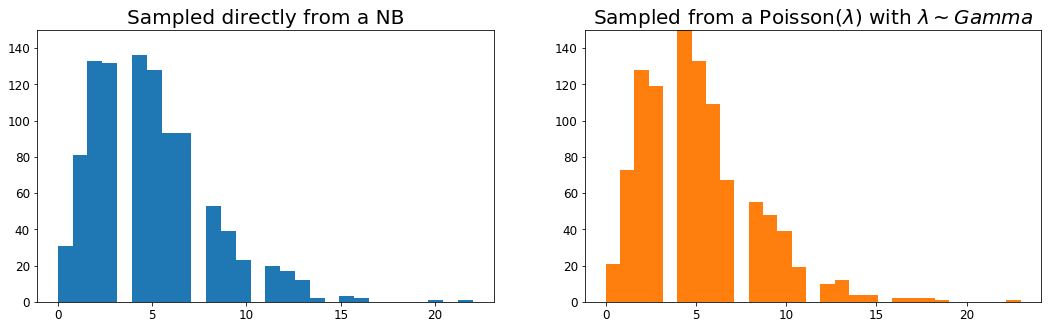

In [4]:
plt.subplot(121)
plt.hist(samples_directly, bins='auto', color='C0')
plt.ylim([0, 150])
plt.title('Sampled directly from a NB')
plt.subplot(122)
plt.ylim([0, 150])
plt.hist(samples_mixture, bins='auto', color='C1');
plt.title(r'Sampled from a Poisson($\lambda$) with $\lambda \sim Gamma$');

## Sample from a Poisson and NB with equal mean but overdispersion in the NB

For the model comparison toy example we want to generate data according to two models, a Poisson model that assumes mean and variance in the data to be equal and a Negative Binomial model that assumes overdispersion. We want our method to do the model comparison based on the overdispersion in the data and not based on differences in the means of the data generated by the models. For both models we define priors on their parameters that influence the means and variances of data sets generated from them, thus, those means and variances will vary from sample to sample. However, we want the mean to be the same on average. So, the expectation of the means under the priors should be the same for both the Poisson and the NB model. 

\begin{align}
\mathbf{E}[\mu_{NB}] &= \mathbf{E}[\mu_{Poi}] \\
\mathbf{E}[r \frac{p}{1-p}] &= \mathbf{E}[\lambda]
\end{align}
If we model the NB indirectly using Poisson-Gamma mixing with Gamma priors on the shape $k$ and scale $\theta$ and use a the conjugate Gamma prior on $\lambda$ for the Poisson model then we have 
\begin{align}
\lambda &\sim Gamma(k_1, \theta_1) \\
r = k &\sim Gamma(k_2, \theta_2) \\
\frac{p}{1-p} = \theta &\sim Gamma(k_3, \theta_3)
\end{align}
Furthermore, because $k$ and $theta$ are independent we have 

\begin{align}
\mathbf{E}[r \frac{p}{1-p}] &= \mathbf{E}[\lambda] \\ 
\mathbf{E}[r] \mathbf{E}[\theta] &= k_1 \theta_1 \\ 
k_2 \theta_2 k_3 \theta_3 &= k_1 \theta_1 \\ 
\end{align}

Given that we will choose all the hyper prior parameter by hand, we can make sure that this condition is satisfied in order to have equal expectations of the means of the models. 

In [5]:
# set the shape or scale of the Gamma prior for the Poisson model
theta1 = 2.0 
# set the shape and scale of the prior on the shape of the Gamma for the mixture to be broad 
theta2 = 2.0
k2 = 5.
# set the shape and scale of the prior on the scale of the Gamma for the mixture to be small 
# this will make the variance and could be the tuning point of the amount of overdispersion / difficulty
theta3 = 1.0 
k3 = 1

# then the scale of the Gamma prior for the Poisson is given by 
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1, theta1)

# get analytical means 
mean_ana_poi = k1 * theta1
mean_ana_nb = k2 * k3 * theta2 * theta3

5.0 2.0


In [6]:
# set the priors 
prior1 = scipy.stats.gamma(a=k1, scale=theta1)
prior2 = scipy.stats.gamma(a=k2, scale=theta2)
prior3 = scipy.stats.gamma(a=k3, scale=theta3)

In [7]:
# generate data 
n_samples = 1000
sample_size = 10
params_poi, samples_poi = sample_poisson(prior1, n_samples, sample_size)
params_nb, samples_nb, lambs_nb = sample_poisson_gamma_mixture(prior2, prior3, n_samples, sample_size)
poi_means, poi_var = samples_poi.mean(axis=1), samples_poi.var(axis=1)
nb_means, nb_var = samples_nb.mean(axis=1), samples_nb.var(axis=1)

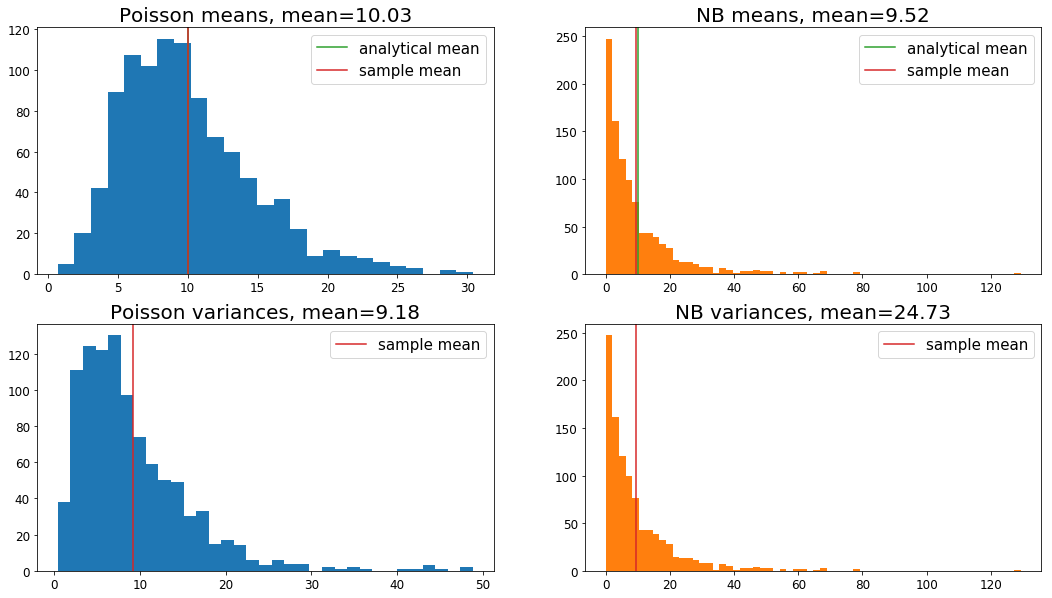

In [8]:
plt.figure(figsize=(18, 10))
plt.subplot(221)
plt.hist(poi_means, bins='auto', color='C0')
plt.title('Poisson means, mean={:.2f}'.format(poi_means.mean()))
plt.axvline(x=mean_ana_poi, label='analytical mean', color='C2')
plt.axvline(x=poi_means.mean(), label='sample mean', color='C3')
plt.legend()

plt.subplot(222)
plt.title('NB means, mean={:.2f}'.format(nb_means.mean()))
plt.hist(nb_means, bins='auto', color='C1'); 
plt.axvline(x=mean_ana_nb, label='analytical mean', color='C2')
plt.axvline(x=nb_means.mean(), label='sample mean', color='C3')
plt.legend();

plt.subplot(223)
plt.title('Poisson variances, mean={:.2f}'.format(poi_var.mean()))
plt.hist(poi_var, bins='auto', color='C0'); 
plt.axvline(x=poi_var.mean(), label='sample mean', color='C3')
plt.legend();

plt.subplot(224)
plt.title('NB variances, mean={:.2f}'.format(nb_var.mean()))
plt.hist(nb_means, bins='auto', color='C1'); 
plt.axvline(x=nb_means.mean(), label='sample mean', color='C3')
plt.legend();          

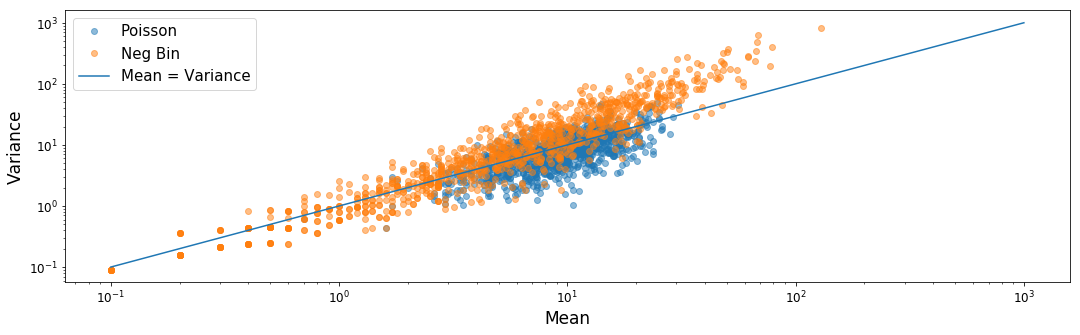

In [9]:
plt.loglog(poi_means, poi_var, 'o', color='C0', alpha=.5, label='Poisson')
plt.ylabel('Variance')
plt.xlabel('Mean')
plt.loglog(nb_means, nb_var, 'o', color='C1', alpha=.5, label='Neg Bin')
plt.loglog(np.logspace(-1, 3, 1000), np.logspace(-1, 3, 1000), label='Mean = Variance')
plt.legend();

## Compare likelihoods of direct and indirect sampling methods

For the evaluation of the marginal likelihood integral it might be necessary to evaluate the direct likelihood instead of the indirect one. The problem with evuluating the indirect one is that one needs to corresponding values of the $\lambda$ parameter sampled from the mixture Gamma. However, when evaluating observed data these are not available. 

**Question**: can we evaluate the marginal likelihood integrant of the direct method even when we used the indirect sampling method to generate the data? 

**Answer**: Yes, if we integrate over $\lambda$ as well. Looking at the derivation of the Poisson-Gamma mixture above we see that it is equivalent to the NB iff integrated over the whole domain of $\lambda$. Thus, 

\begin{align}
\int_r \int_p p_{NB}(X | r, p)p(r, p)drdp &= \int_r \int_p \int_{\lambda} p_{poi}(X|\lambda)p_{Gamma}(\lambda | k, \theta) p(k, \theta) dk d\theta d\lambda \\ 
r = k &; \;\; p = \frac{\theta}{1 + \theta} \\
p(k, \theta) &= p_{Gamma}(k |k_k, \theta_k) p_{Gamma}(\theta |k_{\theta}, \theta_{\theta}) \\ 
\text{To find the prior pdfs for $r$ and $p$ we need a } &\text{change of variables from $\theta$ to $p$ (???) then} \\ 
p(r, p) &= p_{Gamma}(r | k_k, \theta_k) \cdot \frac{1}{(1 - p)^2}p_{Gamma}(\theta |k_{\theta}, \theta_{\theta})
\end{align}

## Now check whether this actually holds: